In [76]:

%load_ext autoreload
%autoreload 2

import os
from functools import partial
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from detecta import detect_peaks
from natsort import natsorted
from tqdm import tqdm

from seisnet import PhaseNetBase
from seisnet.dataloaders import Normalize, random_dataloader, test_dataloader
from seisnet.utils import get_data_dir, get_repo_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load models and perform inference

In [86]:
output_npz_path = f"{get_data_dir()}/test_hawaii"
all_wvfm_pths = glob(f"{output_npz_path}/*.npz")

peaks_thresh = partial(detect_peaks, mph=0.5, mpd=500, show=False)

In [90]:
pred.shape

(1, 3000)

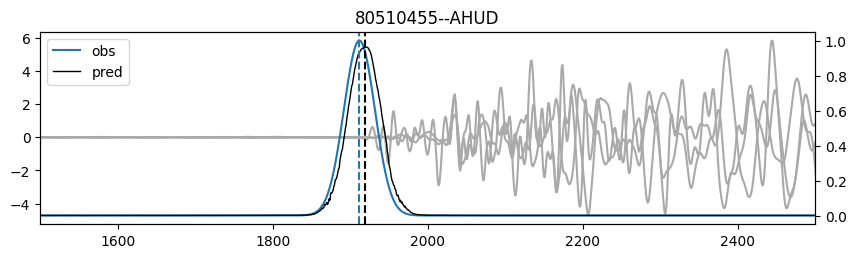

In [97]:
n = 36001 # 16k's

wvfm_pth = all_wvfm_pths[n]
file = np.load(wvfm_pth,allow_pickle=True)

model = PhaseNetBase(classes=1)
# xx = np.concat([file["X"][:,:1600],np.random.uniform(-350,350,(3,1400))],axis=1).astype(np.float32)

model.load_checkpoint(f"{get_repo_dir()}/outputs/best_model_s1019616_d42f3c28.pth")
norm = Normalize("mnstd")
sample = {"X": file["X"], "y": file["y"], #file["X"]
          "pIdx" : file["metadata"][()]["p_phase_index"],
          "sIdx" : file["metadata"][()]["s_phase_index"]}
file = norm(sample)
pred = model.single_predict(file["X"])
pred_p = peaks_thresh(pred.squeeze(0))

fig,ax = plt.subplots(figsize=(10,2.5))
ax.plot(file["X"].T, c="darkgray")
ax.margins(x=0.01)

ax = ax.twinx()
ax.plot(file["y"][0].T,label="obs")
ax.plot(pred[0].T, c="k", lw=1, label="pred")

ax.axvline(sample["pIdx"],ls="--")
ax.axvline(pred_p,ls="--",c="k")

ax.set_title(os.path.basename(wvfm_pth).replace(".npz",""))
ax.margins(x=0.01),ax.legend(loc="upper left")
ax.set_xlim(1500,2500)
plt.show()

# print(file["metadata"])

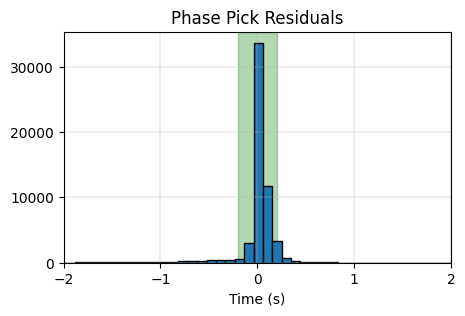

In [117]:
import matplotlib.ticker as ticker

all_rsd = pd.read_csv(f"{get_repo_dir()}/all_residuals.csv")
plt.figure(figsize=(5,3))
plt.axvspan(-0.2, 0.2, color='green', alpha=0.3)
plt.hist(all_rsd["residuals"]/100,bins=500,ec="k")
plt.xlim(-2,2),plt.xlabel("Time (s)")
plt.title("Phase Pick Residuals"), plt.grid(True, lw=0.3)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10e3))

In [ ]:


samples_thresh = 10 
prob_thresh = 0.5



labels_cls_dict = {}
# pred_class_dict[key] = []
# residuals = []
pred_class_dict = {}
for thresh in range(20,92,2):
    prob_thresh = round(thresh/100,2)
    pkey = f"pred_thresh_{prob_thresh}"
    lkey = f"label_thresh_{prob_thresh}"
    pred_class_dict[pkey] = []
    labels_cls_dict[lkey] = []

for idx,(batch) in enumerate(tdl):
    pred = model.batch_predict(batch["X"])
    plabels = batch["pIdx"].detach().numpy()
    # labels_cls.extend(np.ones(len(plabels)))
    for idx,arr in enumerate(pred.squeeze(1)):
        for thresh in range(20,92,2):
            prob_thresh = round(thresh/100,2)
            peaks_thresh = partial(detect_peaks, mph=prob_thresh, mpd=500, show=False)
            pkey = f"pred_thresh_{prob_thresh}"
            lkey = f"label_thresh_{prob_thresh}"
            onsets = peaks_thresh(arr)
            if len(onsets)==1:
                err = onsets[0]-plabels[idx]
                if abs(err) <= samples_thresh:
                    pred_class_dict[pkey].append(1)
                    labels_cls_dict[lkey].append(1)
                else:
                    pred_class_dict[pkey].append(0)
                    labels_cls_dict[lkey].append(1)
                # residuals.append(err)
                continue
            elif len(onsets)>1:
                errs = np.array(onsets)-plabels[idx]
                errs_abs = np.abs(errs)
                closest = errs[np.argmin(errs_abs)]
                # residuals.append(closest)
                if abs(closest) <= samples_thresh:
                    pred_class_dict[pkey].append(1)
                    labels_cls_dict[lkey].append(1)
                else:
                    pred_class_dict[pkey].append(0)
                    labels_cls_dict[lkey].append(1)
                pred_class_dict[pkey].extend(np.ones(len(errs)-1))
                labels_cls_dict[lkey].extend(np.zeros(len(errs)-1))
                continue
            else:
                pred_class_dict[pkey].append(0)
                labels_cls_dict[lkey].append(1)


# correct = (np.array(labels_cls) == np.array(pred_class_dict[key])).sum()
# acc = correct / len(labels_cls)

In [30]:
rct,rcv = [],[]


for key,values in pred_class_dict.items():
    recall_thresh = key.split("_")[-1]
    labels_cls = labels_cls_dict.get(f"label_thresh_{recall_thresh}")
    metric = Recall(task="binary")
    labels_tensor = torch.tensor(labels_cls, device=model.device).to(torch.int)
    pred_tensor = torch.tensor(values, device=model.device).to(torch.float)
    recall_val = metric(pred_tensor,labels_tensor)
    mlf_key = f"Recall_probThresh_{recall_thresh}"
    rct.append(float(recall_thresh))
    rcv.append(recall_val)

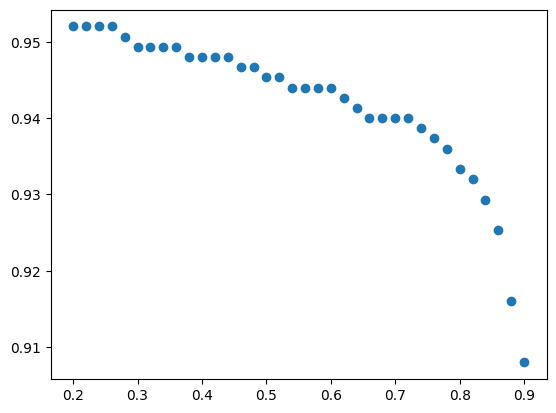

In [26]:
plt.scatter(rct,rcv)

/Users/josesomojola/project/.venv/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


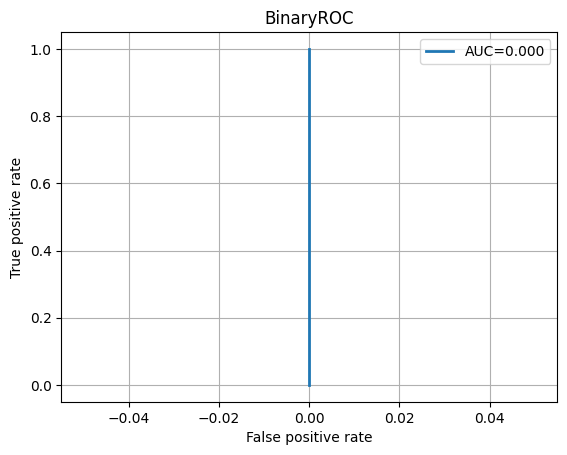

In [28]:
metric = ROC(task="binary")
metric.update(pred_tensor,labels_tensor)
fig_, ax_ = metric.plot(score=True)

In [ ]:



# metric = Recall(task="binary")
# print(metric(torch.tensor(preds_cls),torch.tensor(labels_cls)))
# metric = Accuracy(task="binary")
# print(metric(torch.tensor(preds_cls),torch.tensor(labels_cls)))

# metric = ROC(task="binary")
# print(metric(torch.tensor(preds_cls).to(torch.float),torch.tensor(labels_cls).to(torch.int)))
# metric.update(torch.tensor(preds_cls).to(torch.float),torch.tensor(labels_cls).to(torch.int))
# fig_, ax_ = metric.plot(score=True)

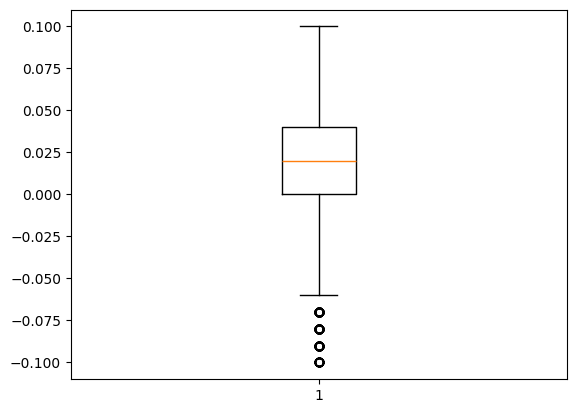

In [75]:
arr = np.array(residuals)

arr = arr[(arr>=-10) & (arr<=10)]
plt.boxplot(arr/100)#, bins=100,ec="k"
# plt.hist(arr)
plt.show()

### Perform predictions on a batch of data

In [13]:
tdl, vdl = random_dataloader(wvfm_dir=f"{get_data_dir()}/train_npz", sample_size=1000, batch_size=512)



In [534]:
batch = next(iter(tdl))

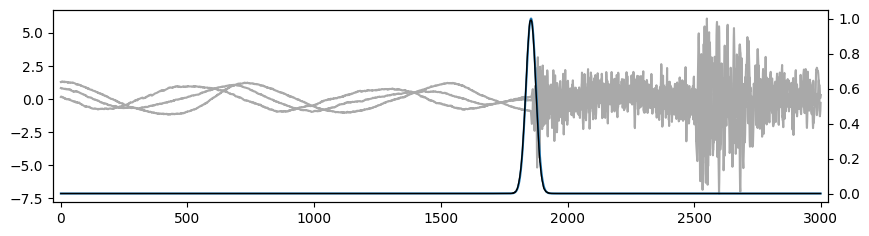

In [554]:
n = 511
wvfm, label = batch["X"][n], batch["y"][n]
pred = model.single_predict(wvfm)

fig,ax = plt.subplots(figsize=(10,2.5))
ax.plot(wvfm.T, c="darkgray")
ax.margins(x=0.01)

ax = ax.twinx()
ax.plot(label.T)
ax.plot(pred[0].T, c="k", lw=1)

plt.show()